# Segmenting water bodies with DeepLab V3
The [Satellite Images of Water Bodies](https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies) dataset consists of a collection of water body images captured by the Sentinel-2 Satellite. The dataset is split in a train and a validation set, each containing 224x224 RGB images. The train set contains 2683 samples and the validation set contains 258 samples. The masks are black and white images, `1` representing water and `0` not water.

The images are scaled so its values range from [0, 1] and a some augmentations are applied to the training set.

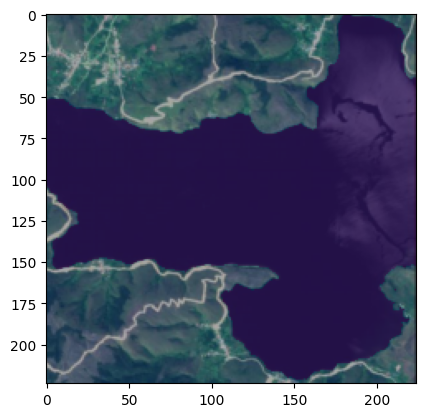

In [1]:
import os
from os import path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch import Tensor
from torch.utils import data
from torch.utils.data import Dataset
import torchvision.transforms.v2.functional as F
import torchvision.utils as vision_utils


TRAIN_PERCENTAGE = 0.8
CLASSES = ["background", "water"]
NUM_CLASSES = len(CLASSES)


class WaterSegmentationDataset(Dataset):

    OUTPUT_SIZE = [224, 224]

    def __init__(self, images_dir: str, labels_dir: str, augmentations: bool = False):
        self.images_dir: str = path.abspath(images_dir)
        self.labels_dir: str = path.abspath(labels_dir)
        self.sample_filenames: list[str] = self.__get_sample_filenames(self.images_dir)
        self.__images: list[np.ndarray] = self.__load_images_to_memory()
        self.__masks: list[np.ndarray] = self.__load_masks_to_memory()
        self.__augmentations: bool = augmentations

    def __len__(self) -> int:
        return len(self.sample_filenames)

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image = self.__images[index]
        mask = self.__masks[index]
        if self.__augmentations:
            transform = A.Compose([
                A.Blur(blur_limit=11),
                A.RandomBrightnessContrast(),
                A.Solarize(),
                A.RandomRotate90()
            ])
            transformed = transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        img = torch.from_numpy(np.transpose(image, (2, 0, 1)))
        target = torch.from_numpy(np.transpose(mask, (2, 0, 1)))[0]
        return img, target

    def __get_sample_filenames(self, images_dir: str) -> list[str]:
        sample_ids = []
        files = os.listdir(images_dir)
        for file in files:
            sample_ids.append(file)
        return sorted(sample_ids)

    def __open_as_rgb_image(self, img_path: str) -> Image.Image:
        with Image.open(img_path) as im:
            rgb_im = im.convert('RGB')
        return rgb_im

    def __load_images_to_memory(self) -> list[np.ndarray]:
        images = []
        for filename in self.sample_filenames:
            image_path = f"{self.images_dir}/{filename}"
            rgb_im = self.__open_as_rgb_image(image_path)
            image = F.pil_to_tensor(rgb_im).float() / 255
            image = F.resize(image, self.OUTPUT_SIZE)
            img_array = np.transpose(image.numpy(), (1, 2, 0))
            images.append(img_array)
        return images

    def __load_masks_to_memory(self) -> list[np.ndarray]:
        masks = []
        for filename in self.sample_filenames:
            label_path = f"{self.labels_dir}/{filename}"
            rgb_mask = self.__open_as_rgb_image(label_path)
            mask = F.pil_to_tensor(rgb_mask)
            mask = F.resize(mask, self.OUTPUT_SIZE)
            mask = self.__encode_water(mask).unsqueeze(0)
            mask_array = np.transpose(mask.numpy(), (1, 2, 0))
            masks.append(mask_array)
        return masks

    def __encode_water(self, mask) -> Tensor:
        greyscale_mask = mask.sum(axis=0) / 3
        hot_encoded_mask = greyscale_mask > 200
        encoded_water_mask = hot_encoded_mask.long()
        return encoded_water_mask


def show_label(dataset: WaterSegmentationDataset, index: int):
    image_arr, mask_arr = dataset[index]
    image = (image_arr * 255).type(torch.uint8)
    mask = mask_arr > 0
    colors = ["#460046", "#D2691E"]
    img = vision_utils.draw_segmentation_masks(image, mask, alpha=0.5, colors=colors)
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def pixel_accuracy(targets, outputs):
    _, predictions = torch.max(outputs.data, 1)
    correct = predictions.eq(targets).sum().item()
    accuracy = correct / torch.numel(targets)
    return accuracy


def print_accuracy_history(train_accuracy: list[float], val_accuracy: list[float]):
    epochs = range(1, len(train_accuracy) + 1)
    plt.figure(figsize=(10, 8), )
    plt.plot(epochs, train_accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b--", label="Validation accuracy")
    plt.title("Training accuracy")
    plt.legend()
    plt.grid()
    plt.show()


def print_loss_history(train_loss: list[float], val_loss: list[float]):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 8), )
    plt.plot(epochs, train_loss, "ro", label="Training loss")
    plt.plot(epochs, val_loss, "r--", label="Validation loss")
    plt.title("Training loss")
    plt.legend()
    plt.grid()
    plt.show()


dataset = WaterSegmentationDataset("data/Water_Bodies_Dataset_Split/train_images",
                                   "data/Water_Bodies_Dataset_Split/train_masks", True)
testset = WaterSegmentationDataset("data/Water_Bodies_Dataset_Split/valid_images",
                                   "data/Water_Bodies_Dataset_Split/valid_masks")
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
show_label(dataset, 1)

From the training set, 80% will be used to optimise the model and 20% will be used for validation.

In [2]:
from torch.utils.data import DataLoader


BATCH_SIZE = 16

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

The model will be loaded to GPU to speed up the process.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


A **DeepLab V3** model trained for the COCO dataset is loaded. The classifiers from the original model will be modified so its outputs match the nubmer of classes in this task.

In [4]:
from torch.nn import Conv2d, Sequential
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3, DeepLabV3_ResNet50_Weights


def load_deeplab() -> DeepLabV3:
    model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
    assert isinstance(model.classifier, Sequential) and isinstance(model.aux_classifier, Sequential)
    classifier_in_channels = model.classifier[4].in_channels
    aux_classifier_in_channels = model.aux_classifier[4].in_channels
    model.classifier[4] = Conv2d(classifier_in_channels, NUM_CLASSES, 1)
    model.aux_classifier[4] = Conv2d(aux_classifier_in_channels, NUM_CLASSES, 1)
    return model


def print_model_performace(model: DeepLabV3, dataset: WaterSegmentationDataset):
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for data in dataset:
            image, label = data[0].unsqueeze(0).to(device), data[1]
            prediction = model(image)['out'].cpu()
            accuracy += pixel_accuracy(label, prediction)
    accuracy /= len(dataset)
    print(f"Accuracy: {accuracy:.5f}")


segmenter = load_deeplab()
segmenter = segmenter.to(device)

After experimenting with different optimizers, `Adam` produced the best result. The following parameters gave the best results. Note that a higher learning rate caused the loss to oscilate.

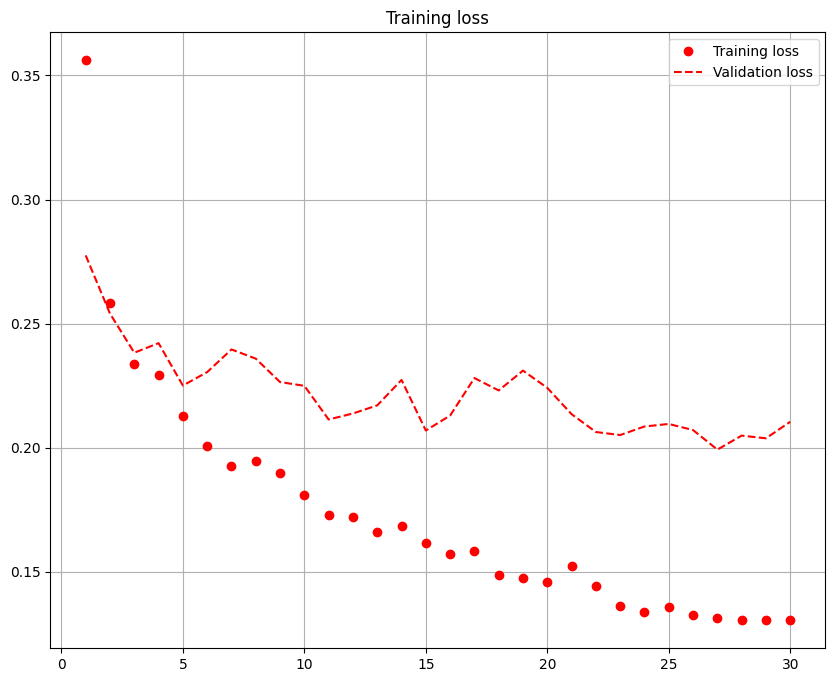

In [5]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


LEARNING_RATE = 0.00005
EPOCHS = 30

criterion = CrossEntropyLoss()
optimizer = Adam(segmenter.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, patience=5)
train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    running_accuracy = 0
    segmenter.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = segmenter(images)['out']
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += pixel_accuracy(labels, outputs)
    val_loss = 0
    val_acc = 0
    segmenter.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = segmenter(images)['out']
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += pixel_accuracy(labels, outputs)
    val_loss = val_loss / len(validation_loader)
    epoch_loss = running_loss / len(train_loader)
    val_acc = val_acc / len(validation_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    train_loss.append(epoch_loss)
    validation_loss.append(val_loss)
    train_accuracy.append(epoch_accuracy)
    validation_accuracy.append(val_acc)
    scheduler.step(val_loss)
print_loss_history(train_loss, validation_loss)

The model has its best performance at 27 epochs, though it oscillated a lot halfway through its training.

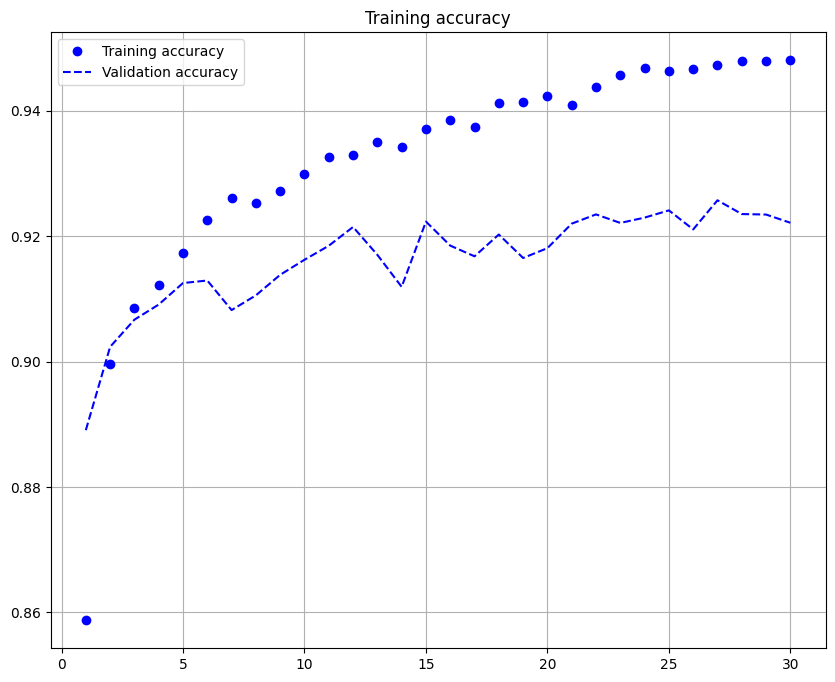

In [6]:
print_accuracy_history(train_accuracy, validation_accuracy)

It's accuracy is >94%

In [7]:
print_model_performace(segmenter, testset)

Accuracy: 0.94387


Next there are some plots of the predictions it does on the test samples.

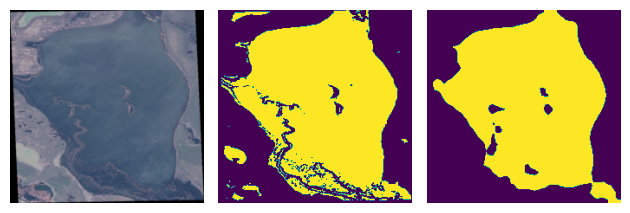

In [8]:
def compare_prediction(index: int):
    segmenter.eval()
    with torch.no_grad():
        image, label = testset[index][0].to(device), testset[index][1].to(device)
        outputs = segmenter(image.unsqueeze(0))['out']
    prediction = torch.max(outputs, dim=1)
    fig, axs = plt.subplots(1, 3, layout='tight')
    axs[0].imshow(image.permute((1, 2, 0)).cpu())
    axs[1].imshow(label.cpu() * 127)
    axs[2].imshow(prediction.indices.permute((1, 2, 0)).cpu() * 200)
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    axs[2].set_axis_off()
    fig.show()


compare_prediction(1)

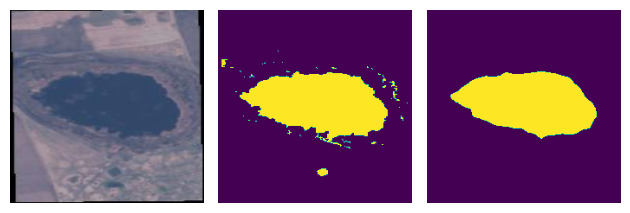

In [9]:
compare_prediction(6)

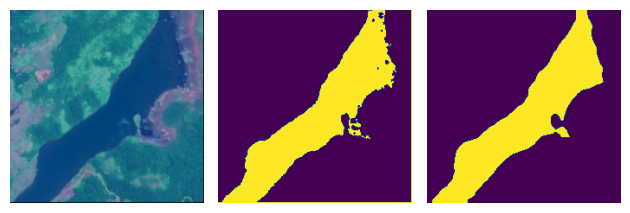

In [10]:
compare_prediction(7)